This is a simple LSTM test with the goal to train to predict a sine wave using PyTorch.

In [1]:
# Created by Davide Pasca - 2023/07/27

import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Tuple

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

#device = "cpu"
print("Using device:", device)

Using device: cuda


We use actual time values to have a realistic view of the number of samples involved if this were about predicting market data.
Of course, the actual price data would be much different.

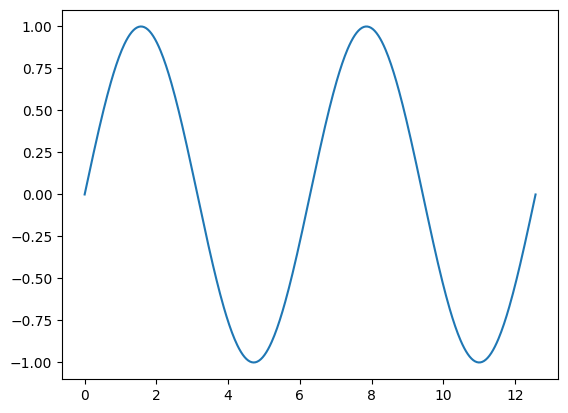

In [3]:
# Total data points
num_points = 500

# Generate the sine wave data
x = np.linspace(0, 4 * np.pi, num_points)
y = np.sin(x)

# Plot the sine wave
plt.plot(x, y)
plt.show()

In [4]:
# The sequence length will be the number of time steps that our model will consider for its predictions
sequence_length = 50

def create_sequences(input_data, seq_length):
    """
    Create sequences from the input time series data.
    """
    sequences = []
    length = len(input_data)

    for i in range(length - seq_length):
        seq = input_data[i:i + seq_length]
        label = input_data[i + seq_length:i + seq_length + 1]
        sequences.append((seq, label))

    return sequences

# Normalize the data
y_normalized = (y - y.mean()) / y.std()

# Create the sequences
sequences = create_sequences(y_normalized, sequence_length)

# Convert sequences to numpy arrays first, then to PyTorch tensors
sequence_data = [(torch.from_numpy(np.array(seq)).unsqueeze(1).float().to(device), torch.tensor(label).float().to(device)) for seq, label in sequences]

In [5]:
# 80% of the data will be used for training
train_size = int(len(sequence_data) * 0.8)

train_data = sequence_data[:train_size]
test_data = sequence_data[train_size:]

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, seq_len=50, num_layers=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=1,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        # Shift the input sequence one step to the right to create the target sequence.
        # Zero-pad the shifted sequence at the beginning to maintain the same length.
        # Also move the new tensor to the device.
        tgt = torch.cat([torch.zeros(1, 1, self.hidden_dim).to(device), x[:-1,:,:]], dim=0)
        x = self.transformer(x, tgt)
        x = self.fc(x)
        return x

model = TransformerModel()
model = model.to(device)

Epoch 100/100
Train loss: 0.0081
Target loss: 0.0827


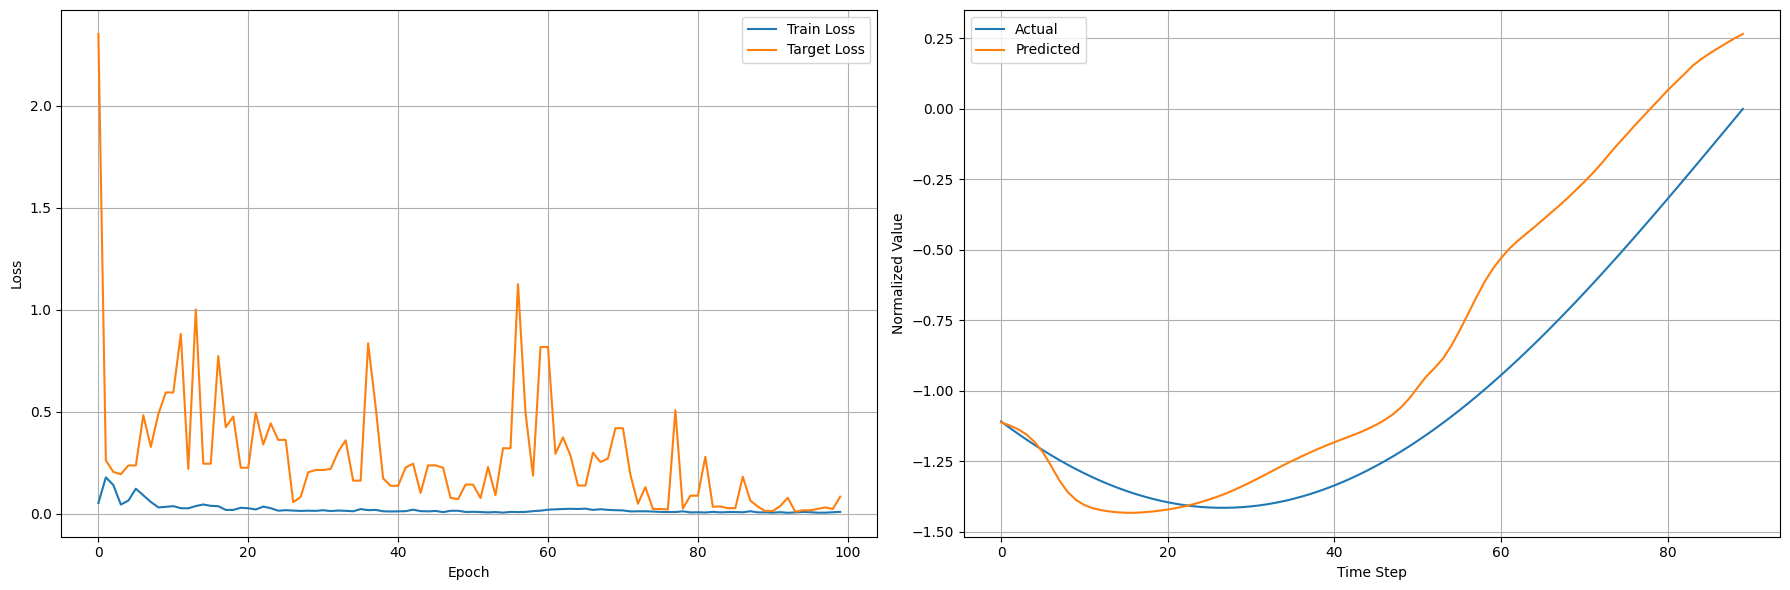

In [7]:
# torch seed to 0
torch.manual_seed(0)

# Define loss function and optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Number of epochs
epochs = 100

# For storing losses
train_losses = []
target_losses = []

# For plotting losses
plt.ion()

last_update_time = time.time()
last_update_epoch = -1

for epoch in range(epochs):
    # Training
    train_loss = 0.0
    for seq, label in train_data:
        # Reset the gradients
        optimizer.zero_grad()
        # Add batch dimension
        seq = seq.unsqueeze(1)
        # Forward pass
        output = model(seq).squeeze()
        # Compute the loss
        loss = criterion(output[-1], label.squeeze())
        train_loss += loss.item()
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
    # Average training loss for this epoch
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    # Compute loss on target data
    if epoch == 0 or epoch == epochs - 1 or (epoch % 5):
      target_loss = 0
      for seq, label in test_data:
          seq = seq.unsqueeze(1)
          output = model(seq).squeeze()
          target_loss += criterion(output[-1], label.squeeze()).item()
      target_loss /= len(test_data)
      target_losses.append(target_loss)
    else:
      # append the previous target loss
      target_losses.append(target_losses[-1])

    # Print losses
    if (time.time() > (last_update_time+5) and last_update_epoch != epoch) or epoch == 0 or epoch == epochs - 1:
        model.eval()
        # Generate predictions on the test set
        test_predictions = []
        for seq, label in test_data:
            seq = seq.unsqueeze(1)
            output = model(seq)
            test_predictions.append(output[-1].item())
        model.train()

        clear_output(wait=True)
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train loss: {train_loss:.4f}')
        print(f'Target loss: {target_loss:.4f}')

        # Plot losses and predictions
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

        # Plot losses
        axs[0].plot(train_losses, label='Train Loss')
        axs[0].plot(target_losses, label='Target Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)

        # Plot the actual values and the predictions
        axs[1].plot([label.item() for _, label in test_data], label='Actual')
        axs[1].plot(test_predictions, label='Predicted')
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Normalized Value')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

plt.ioff()
